In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.nn.utils import clip_grad_norm
import numpy as np
import math

from scipy.misc import imresize
import matplotlib.pyplot as plt

import time
import copy
import os

In [71]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test1': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'E:/Users/Ranet/Desktop/Machine Learning/FAST.AI/v2/fastai/courses/dl1/data/dogscats'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test1']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=False, num_workers=4)
              for x in ['train', 'valid']}

dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['test1']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test1']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

E:\Users\Ranet\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
E:\Users\Ranet\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [72]:
dataiter = iter(dataloaders_test['test1'])

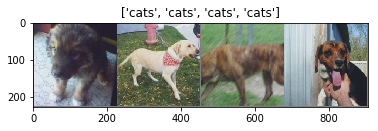

In [76]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = torch.from_numpy(inp).sigmoid() # * inp + mean
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(dataiter)

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters())
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

In [20]:
# SAVE AND LOAD MODEL
#torch.save(model_conv.state_dict(), 'saved_5_epochs_resnet18')
model = model_conv
model.load_state_dict(torch.load('saved_5_epochs_resnet18'))

In [34]:
# PREDICT ON T

outputs, preds = [], []
softmax = nn.Softmax()

for data in dataloaders_test['test1']:
    # get the inputs
    inputs, _ = data

    # wrap them in Variable
    if use_gpu:
        inputs = Variable(inputs.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
        
    # forward
    output = softmax(model(inputs))    
    _, pred = torch.max(output.data, 1) 
    
    outputs.append(output)
    preds.append(pred)

E:\Users\Ranet\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


In [51]:
print(len(outputs))

#outputs_2 = [pred[1] for pred in [batch.data.cpu().numpy() in outputs]]
outputs_2 = [] # to unroll batches of 4 and get only one class probability
for batch in outputs:
    for pred in batch.data.cpu().numpy():
        outputs_2.append(pred[1])


print(len(outputs_2))
print(outputs_2[0:5])

3125
12500
[0.9945017, 0.0029906, 0.043356482, 0.9970554, 0.9987531]


In [53]:
with open('submission-file.csv', 'w') as f:
    f.write('id,label\n')
    
with open('submission-file.csv', 'a') as f:
        for num, pred in enumerate(outputs_2):
            f.write('{},{}\n'.format(num+1, pred))